In [1]:
#some useful packages for your analysis 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import statsmodels
from scipy import stats
from scipy.stats import levene
import scipy.stats
import math
import random
import statistics
import scipy.stats as sp
from sklearn import linear_model
import seaborn as sns

!pip install scikit_posthocs
!pip install researchpy
import researchpy as rp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


https://www.kaggle.com/datasets/uciml/student-alcohol-consumption

Attributes for both student-mat.csv (Math course) and student-por.csv (Portuguese language course) datasets:
  
Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education).  


      

G1 - first period grade (numeric: from 0 to 20). 
  
G2 - second period grade (numeric: from 0 to 20). 
  
G3 - final grade (numeric: from 0 to 20, output target). 


# Preprocessing 

In [8]:
##Combine the two datasets (mathdf and pordf together)##
#add a column indicating if that row in the dataframe is for math or Portugese class
#API reference: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html
mathdf['subject']='math'
mathdf['subject']=mathdf['subject'].astype('string')
pordf['subject']='portuguese'
pordf['subject']=pordf['subject'].astype('string')


#concat the two dataframes together 
dataset = pd.concat([mathdf,pordf],axis=0)
dataset.reset_index(inplace=True)

##Function to clean the dataframes##
def cleandata(filename):
  """
  Takes in csv file name in the format 'file_name.csv'
  Changes categorical variable columns and binary ordinal variable ('famsize' column) into string type
  Returns cleaned dataframe 
  """
  #load data
  mydf = pd.read_csv(filename) 

  #change categorical variables to string type
  mydf[['school', 'sex', 'address', 'Pstatus','Mjob','Fjob','reason','guardian','schoolsup','famsup','paid','activities',
        'nursery','higher','internet','romantic']]=mydf[['school', 'sex', 'address', 'Pstatus','Mjob','Fjob','reason','guardian',
                                                         'schoolsup','famsup','paid','activities','nursery','higher','internet','romantic']].astype('string')
  #change 'famsize' column into string type too in case we use pd.get_dummies later 
  mydf['famsize']=mydf['famsize'].astype('string')
  return mydf

# Load Data

In [ ]:
##Load the clean dataset files##
mathdf = cleandata('student-mat.csv') 
pordf = cleandata('student-por.csv') 

# EDA

In [9]:
dataset.head()

,index,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,subject
0,0,GP,F,18,U,GT3,A,4,4,at_home,...,3,4,1,1,3,6,5,6,6,math
1,1,GP,F,17,U,GT3,T,1,1,at_home,...,3,3,1,1,3,4,5,5,6,math
2,2,GP,F,15,U,LE3,T,1,1,at_home,...,3,2,2,3,3,10,7,8,10,math
3,3,GP,F,15,U,GT3,T,4,2,health,...,2,2,1,1,5,2,15,14,15,math
4,4,GP,F,16,U,GT3,T,3,3,other,...,3,2,1,2,5,4,6,10,10,math


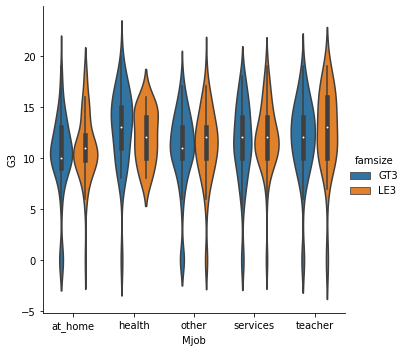

In [15]:
sns.catplot(data=dataset, kind="violin", x="Mjob", y="G3", hue="famsize")

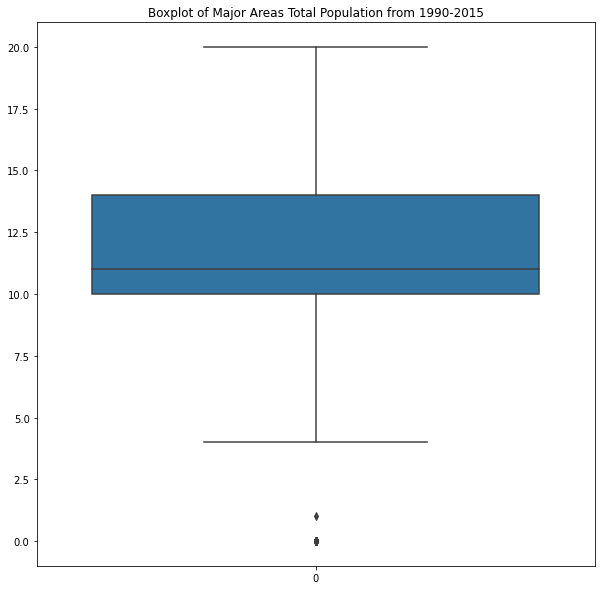

In [10]:
plt.figure(figsize= (10,10))
sns.boxplot(data = dataset['G3'])
plt.title('Boxplot showing distribution of G3 grades for students')
plt.xlabel('')
plt.ylabel('')
plt.show()

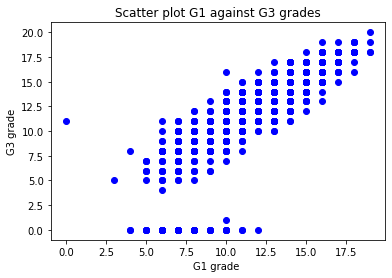

In [24]:
plt.scatter(dataset['G1'], dataset['G3'], color='blue')

plt.xlabel("G1 grade ")
plt.ylabel("G3 grade")
plt.title("Scatter plot G1 against G3 grades")
plt.show()

# T tests

In [29]:
#degrees of freedom code for Welch test 
#code from https://pythonfordatascienceorg.wordpress.com/welch-t-test-python-pandas/ (values checked against R output)

def welch_dof(x, y): 
    '''
    Takes in final grades for binary features
    Returns degrees of freedom 
    '''
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
    return dof

In [25]:
##Conduct family size t-test (LE3 is less than 3, GT3 is greater than 3)##

#create family size groups from dataset 
LE3_famsize = dataset[dataset['famsize']=='LE3']
GT3_famsize = dataset[dataset['famsize']=='GT3']


LE3_G3 = LE3_famsize['G3']
GT3_G3 = GT3_famsize['G3']

#conduct ttest
print('Ttest results for period 3 grades:',stats.ttest_ind(LE3_G3, GT3_G3, equal_var=False)) #p value is significant

Ttest results for period 3 grades: Ttest_indResult(statistic=2.091111791391883, pvalue=0.03690810440658107)


In [26]:
#calculate mean and standard deviation of groups 
#those with less than 3 in family show higher mean average score 
print('Mean Grades for period 3, LE3, GT3:',LE3_G3.mean(), GT3_G3.mean())
print('Standard deviation for period 3, LE3, GT3:',LE3_G3.std(), GT3_G3.std())

Mean Grades for period 3, LE3, GT3: 11.709150326797385 11.18970189701897
Standard deviation for period 3, LE3, GT3: 3.500404837984712 3.998548198952353


In [27]:
# compute confidence interval 
import statsmodels.stats.api as sms
cm = sms.CompareMeans(sms.DescrStatsW(LE3_G3), sms.DescrStatsW(GT3_G3))
print('Confidence interval for period 3:',cm.tconfint_diff(usevar='unequal'))

Confidence interval for period 3: (0.03166431552138754, 1.007232544035441)


In [30]:
#welch dof 
print('DOF for period 3:',welch_dof(LE3_G3, GT3_G3))

DOF for period 3: 646.0546929322937


Example writeup: The results indicate that the mean final grade for students with family size less than three (3) (M=11.71, SD=3.50) is higher than the mean final grade for students with a family size greater than three (3) (M=11.19, SD=4.00). With alpha established at 0.05, this is a statistically significant difference as the p-value (0.036) is less than 0.05, 95% CI [0.03, 1.01]. Therefore, we can reject the null hypothesis that there is no difference in final grades for students with family size less than three (3) and family size greater than three (3).

#Interaction plots 

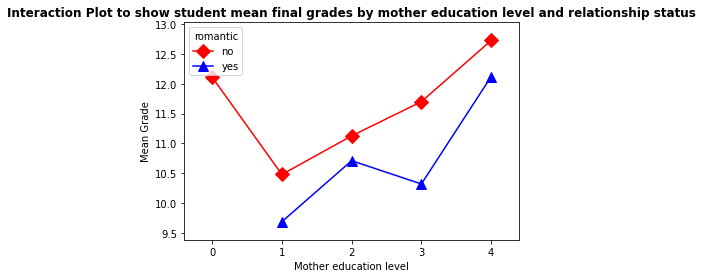

In [7]:
#plot an interaction plot 
#refer to: https://www.statsmodels.org/dev/generated/statsmodels.graphics.factorplots.interaction_plot.html
from statsmodels.graphics.factorplots import interaction_plot

ROMANTIC = dataset['romantic'].astype("category")
final_grade = dataset['G3'].values


rq_2_interaction = interaction_plot(dataset['Medu'], ROMANTIC, final_grade, colors=['red','blue'], markers=['D','^'], ms=10)
#x axis(m_edu), trace (romantic status of the student), dependent variable (mean grade)


plt.ylabel('Mean Grade')
plt.xlabel('Mother education level')
plt.title('Interaction Plot to show student mean final grades by mother education level and relationship status', fontweight='bold')
plt.show()

Example writeup: While the interaction plot does not provide any information on statistically significant difference, the plot showed: (a) students not in a relationship have a higher average grade compared to students in a relationship; (b) there are no students who have a mother with no education and are in a relationship; and (c) there was a noticeable big difference in average grades between students whose mother had secondary level education but different in relationship status (N3 vs. Y3)